In [ ]:
# This mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive')

# TODO: Enter the foldername in your Drive where you have saved this notebook
# e.g. 'CSE156/assignments/PA3/'
FOLDERNAME = "ImageCaption/"
assert FOLDERNAME is not None, "[!] Enter the foldername."


import sys
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))

%cd /content/drive/My\ Drive/$FOLDERNAME/

In [2]:
import kagglehub
flickr8k_path = kagglehub.dataset_download('adityajn105/flickr8k')

print('Data source import complete.')

100%|██████████| 1.04G/1.04G [00:12<00:00, 89.2MB/s]


Extracting files...
Data source import complete.


In [3]:
flickr8k_path

'/root/.cache/kagglehub/datasets/adityajn105/flickr8k/versions/1'

In [4]:
import pandas as pd
import numpy as np
from collections import Counter, defaultdict
from PIL import Image
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import math
import pickle
import gc
import random
import warnings
from IPython.display import display

from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torchvision
from torchvision import transforms

warnings.filterwarnings('ignore')
pd.set_option('display.max_colwidth', None)

## Read Data

In [5]:
df = pd.read_csv(".."+flickr8k_path+"/captions.txt", sep=',')
print(len(df))
display(df.head(3))

40455


image  \
0  1000268201_693b08cb0e.jpg   
1  1000268201_693b08cb0e.jpg   
2  1000268201_693b08cb0e.jpg   

                                                                    caption  
0  A child in a pink dress is climbing up a set of stairs in an entry way .  
1                                     A girl going into a wooden building .  
2                          A little girl climbing into a wooden playhouse .

## Data Preprocessing
- Remove Single Character and non alpha Words.
- Add <Start>, <end> and <pad> tokens. <pad> token is appended such that length in max_seq_len

In [6]:
def remove_single_char_word(word_list):
    lst = []
    for word in word_list:
        if len(word)>1:
            lst.append(word)

    return lst

In [7]:
df['cleaned_caption'] = df['caption'].apply(lambda caption : ['<start>'] + [word.lower() if word.isalpha() else '' for word in caption.split(" ")] + ['<end>'])
df['cleaned_caption']  = df['cleaned_caption'].apply(lambda x : remove_single_char_word(x))

In [8]:
df['seq_len'] = df['cleaned_caption'].apply(lambda x : len(x))
max_seq_len = df['seq_len'].max()
print(max_seq_len)

33


In [9]:
df.drop(['seq_len'], axis = 1, inplace = True)
df['cleaned_caption'] = df['cleaned_caption'].apply(lambda caption : caption + ['<pad>']*(max_seq_len-len(caption)) )

In [10]:
display(df.head(2))

image  \
0  1000268201_693b08cb0e.jpg   
1  1000268201_693b08cb0e.jpg   

                                                                    caption  \
0  A child in a pink dress is climbing up a set of stairs in an entry way .   
1                                     A girl going into a wooden building .   

                                                                                                                                                                                                                               cleaned_caption  
0                       [<start>, child, in, pink, dress, is, climbing, up, set, of, stairs, in, an, entry, way, <end>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>]  
1  [<start>, girl, going, into, wooden, building, <end>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>]

## Create Vocab and mapping of token to ID

In [11]:
word_list = df['cleaned_caption'].apply(lambda x : " ".join(x)).str.cat(sep = ' ').split(' ')
word_dict = Counter(word_list)
word_dict =  sorted(word_dict, key=word_dict.get, reverse=True)

In [12]:
print(word_dict[:5])

['<pad>', '<start>', '<end>', 'in', 'the']


In [13]:
vocab_size = len(word_dict)
print(vocab_size)

8360


In [14]:
index_to_word = {index: word for index, word in enumerate(word_dict)}
word_to_index = {word: index for index, word in enumerate(word_dict)}
print(len(index_to_word), len(word_to_index))

8360 8360


### Covert sequence of tokens to IDs

In [15]:
df['text_seq']  = df['cleaned_caption'].apply(lambda caption : [word_to_index[word] for word in caption] )

In [16]:
display(df.head(2))

image  \
0  1000268201_693b08cb0e.jpg   
1  1000268201_693b08cb0e.jpg   

                                                                    caption  \
0  A child in a pink dress is climbing up a set of stairs in an entry way .   
1                                     A girl going into a wooden building .   

                                                                                                                                                                                                                               cleaned_caption  \
0                       [<start>, child, in, pink, dress, is, climbing, up, set, of, stairs, in, an, entry, way, <end>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>]   
1  [<start>, girl, going, into, wooden, building, <end>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>]   

                                                                                                                text_seq  
0  [1, 41, 3, 89, 168, 6, 118, 52, 392, 11, 389, 3, 27, 5075, 690, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]  
1            [1, 18, 311, 63, 192, 116, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [17]:
df = df.sort_values(by = 'image')
split1 = 0.85
split2 = 0.95
train = df.iloc[:int(split1*len(df))]
valid = df.iloc[int(split1*len(df)):int(split2*len(df))]
test = df.iloc[int(split2*len(df)):]

In [18]:
print(len(train), train['image'].nunique())
print(len(valid), valid['image'].nunique())
print(len(test), test['image'].nunique())

34386 6878
4046 810
2023 405


## Using CNN

In [19]:
train_samples = len(train)
print(train_samples)

34386


In [20]:
unq_train_imgs = train[['image']].drop_duplicates()
unq_valid_imgs = valid[['image']].drop_duplicates()
unq_test_imgs = test[['image']].drop_duplicates()
print(len(unq_train_imgs), len(unq_valid_imgs), len(unq_test_imgs))

6878 810 405


In [21]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [22]:
class ImageDataSet():
    def __init__(self, data):
        self.data = data
        self.scaler = transforms.Resize([224, 224])
        self.normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        self.to_tensor = transforms.ToTensor()

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image_name = self.data.iloc[idx]['image']
        img_loc = '..' + flickr8k_path + '/Images/'+str(image_name)

        img = Image.open(img_loc)
        t_img = self.normalize(self.to_tensor(self.scaler(img)))

        return image_name, t_img

In [23]:
train_ImageDataset = ImageDataSet(unq_train_imgs)
train_ImageDataloader = DataLoader(train_ImageDataset, batch_size = 1, shuffle=False)

In [24]:
valid_ImageDataset = ImageDataSet(unq_valid_imgs)
valid_ImageDataloader = DataLoader(valid_ImageDataset, batch_size = 1, shuffle=False)

In [25]:
test_ImageDataset = ImageDataSet(unq_test_imgs)
test_ImageDataloader = DataLoader(test_ImageDataset, batch_size = 1, shuffle=False)

In [26]:
resnet18 = torchvision.models.resnet18(pretrained=True).to(device)
resnet18.eval()

list(resnet18._modules)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 83.6MB/s]


['conv1',
 'bn1',
 'relu',
 'maxpool',
 'layer1',
 'layer2',
 'layer3',
 'layer4',
 'avgpool',
 'fc']

In [27]:
resNet18Layer4 = resnet18._modules.get('layer4').to(device)

In [28]:
def get_vector(t_img):
    t_img = Variable(t_img)
    my_embedding = torch.zeros(1, 512, 7, 7)

    def copy_data(m, i, o):
        my_embedding.copy_(o.data)

    h = resNet18Layer4.register_forward_hook(copy_data)
    resnet18(t_img)
    h.remove()

    return my_embedding

In [29]:
extract_img_train = {}
for image_name, t_img in tqdm(train_ImageDataloader):
    t_img = t_img.to(device)
    embd = get_vector(t_img)

    extract_img_train[image_name[0]] = embd

  0%|          | 0/6878 [00:00<?, ?it/s]

In [30]:
a_file = open("./EncodedImageTrainResNet.pkl", "wb")
pickle.dump(extract_img_train, a_file)
a_file.close()

In [31]:
extract_img_valid = {}
for image_name, t_img in tqdm(valid_ImageDataloader):
    t_img = t_img.to(device)
    embd = get_vector(t_img)

    extract_img_valid[image_name[0]] = embd

  0%|          | 0/810 [00:00<?, ?it/s]

In [32]:
a_file = open("./EncodedImageValidResNet.pkl", "wb")
pickle.dump(extract_img_valid, a_file)
a_file.close()

In [33]:
extract_img_test = {}
for image_name, t_img in tqdm(test_ImageDataloader):
    t_img = t_img.to(device)
    embd = get_vector(t_img)

    extract_img_test[image_name[0]] = embd

  0%|          | 0/405 [00:00<?, ?it/s]

In [34]:
a_file = open("./EncodedImageTestResNet.pkl", "wb")
pickle.dump(extract_img_test, a_file)
a_file.close()

In [35]:
class CaptionDataSet():
    def __init__(self, data, pkl_file):
        self.data = data
        self.encodedImgs = pd.read_pickle(pkl_file)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        caption_seq = self.data.iloc[idx]['text_seq']
        target_seq = caption_seq[1:]+[0]

        image_name = self.data.iloc[idx]['image']
        image_tensor = self.encodedImgs[image_name]
        image_tensor = image_tensor.permute(0,2,3,1)
        image_tensor_view = image_tensor.view(image_tensor.size(0), -1, image_tensor.size(3))

        return torch.tensor(caption_seq), torch.tensor(target_seq), image_tensor_view

In [36]:
train_dataset_resnet = CaptionDataSet(train, 'EncodedImageTrainResNet.pkl')
train_dataloader_resnet = DataLoader(train_dataset_resnet, batch_size = 32, shuffle=True)

In [37]:
valid_dataset_resnet = CaptionDataSet(valid, 'EncodedImageValidResNet.pkl')
valid_dataloader_resnet = DataLoader(valid_dataset_resnet, batch_size = 32, shuffle=True)

In [38]:
test_dataset_resnet = CaptionDataSet(valid, 'EncodedImageTestResNet.pkl')
test_dataloader_resnet = DataLoader(test_dataset_resnet, batch_size = 32, shuffle=True)

### Position Embedding

In [39]:
class PositionalEncoding(nn.Module):

    def __init__(self, d_model, dropout=0.1, max_len=max_seq_len):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)


    def forward(self, x):
        if self.pe.size(0) < x.size(0):
            self.pe = self.pe.repeat(x.size(0), 1, 1).to(device)
        self.pe = self.pe[:x.size(0), : , : ]

        x = x + self.pe
        return self.dropout(x)

## Transformer Decoder

In [40]:
class ImageCaptionModel(nn.Module):
    def __init__(self, n_head, n_decoder_layer, vocab_size, embedding_size):
        super(ImageCaptionModel, self).__init__()
        self.pos_encoder = PositionalEncoding(embedding_size, 0.1)
        self.TransformerDecoderLayer = nn.TransformerDecoderLayer(d_model =  embedding_size, nhead = n_head)
        self.TransformerDecoder = nn.TransformerDecoder(decoder_layer = self.TransformerDecoderLayer, num_layers = n_decoder_layer)
        self.embedding_size = embedding_size
        self.embedding = nn.Embedding(vocab_size , embedding_size)
        self.last_linear_layer = nn.Linear(embedding_size, vocab_size)
        self.init_weights()

    def init_weights(self):
        initrange = 0.1
        self.embedding.weight.data.uniform_(-initrange, initrange)
        self.last_linear_layer.bias.data.zero_()
        self.last_linear_layer.weight.data.uniform_(-initrange, initrange)

    def generate_Mask(self, size, decoder_inp):
        decoder_input_mask = (torch.triu(torch.ones(size, size)) == 1).transpose(0, 1)
        decoder_input_mask = decoder_input_mask.float().masked_fill(decoder_input_mask == 0, float('-inf')).masked_fill(decoder_input_mask == 1, float(0.0))

        decoder_input_pad_mask = decoder_inp.float().masked_fill(decoder_inp == 0, float(0.0)).masked_fill(decoder_inp > 0, float(1.0))
        decoder_input_pad_mask_bool = decoder_inp == 0

        return decoder_input_mask, decoder_input_pad_mask, decoder_input_pad_mask_bool

    def forward(self, encoded_image, decoder_inp):
        encoded_image = encoded_image.permute(1,0,2)


        decoder_inp_embed = self.embedding(decoder_inp)* math.sqrt(self.embedding_size)

        decoder_inp_embed = self.pos_encoder(decoder_inp_embed)
        decoder_inp_embed = decoder_inp_embed.permute(1,0,2)


        decoder_input_mask, decoder_input_pad_mask, decoder_input_pad_mask_bool = self.generate_Mask(decoder_inp.size(1), decoder_inp)
        decoder_input_mask = decoder_input_mask.to(device)
        decoder_input_pad_mask = decoder_input_pad_mask.to(device)
        decoder_input_pad_mask_bool = decoder_input_pad_mask_bool.to(device)


        decoder_output = self.TransformerDecoder(tgt = decoder_inp_embed, memory = encoded_image, tgt_mask = decoder_input_mask, tgt_key_padding_mask = decoder_input_pad_mask_bool)

        final_output = self.last_linear_layer(decoder_output)

        return final_output,  decoder_input_pad_mask


##  Train the Model

In [ ]:
EPOCH = 30

In [ ]:
ictModel = ImageCaptionModel(16, 4, vocab_size, 512).to(device)
optimizer = torch.optim.AdamW(ictModel.parameters(), lr = 0.00001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor = 0.8, patience=2, verbose = True)
criterion = torch.nn.CrossEntropyLoss(reduction='none')
min_val_loss = float('Inf')

In [ ]:
for epoch in tqdm(range(EPOCH)):
    total_epoch_train_loss = 0
    total_epoch_valid_loss = 0
    total_train_words = 0
    total_valid_words = 0
    ictModel.train()

    ### Train Loop
    for caption_seq, target_seq, image_embed in train_dataloader_resnet:

        optimizer.zero_grad()

        image_embed = image_embed.squeeze(1).to(device)
        caption_seq = caption_seq.to(device)
        target_seq = target_seq.to(device)

        output, padding_mask = ictModel.forward(image_embed, caption_seq)
        output = output.permute(1, 2, 0)

        loss = criterion(output,target_seq)

        loss_masked = torch.mul(loss, padding_mask)

        final_batch_loss = torch.sum(loss_masked)/torch.sum(padding_mask)

        final_batch_loss.backward()
        optimizer.step()
        total_epoch_train_loss += torch.sum(loss_masked).detach().item()
        total_train_words += torch.sum(padding_mask)


    total_epoch_train_loss = total_epoch_train_loss/total_train_words


    ### Eval Loop
    ictModel.eval()
    with torch.no_grad():
        for caption_seq, target_seq, image_embed in valid_dataloader_resnet:

            image_embed = image_embed.squeeze(1).to(device)
            caption_seq = caption_seq.to(device)
            target_seq = target_seq.to(device)

            output, padding_mask = ictModel.forward(image_embed, caption_seq)
            output = output.permute(1, 2, 0)

            loss = criterion(output,target_seq)

            loss_masked = torch.mul(loss, padding_mask)

            total_epoch_valid_loss += torch.sum(loss_masked).detach().item()
            total_valid_words += torch.sum(padding_mask)

    total_epoch_valid_loss = total_epoch_valid_loss/total_valid_words

    print("Epoch -> ", epoch," Training Loss -> ", total_epoch_train_loss.item(), "Eval Loss -> ", total_epoch_valid_loss.item() )

    if min_val_loss > total_epoch_valid_loss:
        print("Writing Model at epoch ", epoch)
        torch.save(ictModel, './BestModel_2')
        min_val_loss = total_epoch_valid_loss


    scheduler.step(total_epoch_valid_loss.item())


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch ->  0  Training Loss ->  4.9469218254089355 Eval Loss ->  4.330336570739746
Writing Model at epoch  0
Epoch ->  1  Training Loss ->  4.197713851928711 Eval Loss ->  3.9827752113342285
Writing Model at epoch  1
Epoch ->  2  Training Loss ->  3.9090611934661865 Eval Loss ->  3.7999463081359863
Writing Model at epoch  2
Epoch ->  3  Training Loss ->  3.72298526763916 Eval Loss ->  3.6782925128936768
Writing Model at epoch  3
Epoch ->  4  Training Loss ->  3.5821356773376465 Eval Loss ->  3.588320255279541
Writing Model at epoch  4
Epoch ->  5  Training Loss ->  3.468458652496338 Eval Loss ->  3.5166637897491455
Writing Model at epoch  5
Epoch ->  6  Training Loss ->  3.371366500854492 Eval Loss ->  3.4631900787353516
Writing Model at epoch  6
Epoch ->  7  Training Loss ->  3.2870819568634033 Eval Loss ->  3.4203667640686035
Writing Model at epoch  7
Epoch ->  8  Training Loss ->  3.210939645767212 Eval Loss ->  3.386080026626587
Writing Model at epoch  8
Epoch ->  9  Training Loss -

## Generate Captions

In [41]:
model = torch.load('./BestModel_1')
start_token = word_to_index['<start>']
end_token = word_to_index['<end>']
pad_token = word_to_index['<pad>']
max_seq_len = 33
print(start_token, end_token, pad_token)

1 2 0


In [42]:
test_img_embed = pd.read_pickle('EncodedImageTestResNet.pkl')

In [43]:
def generate_caption(K, img_nm):
    img_loc = '..' + flickr8k_path + '/Images/'+str(img_nm)
    image = Image.open(img_loc).convert("RGB")
    plt.imshow(image)

    model.eval()
    test_img_df = test[test['image']==img_nm]
    print("Actual Caption : ")
    print(test_img_df['caption'].tolist())
    img_embed = test_img_embed[img_nm].to(device)


    img_embed = img_embed.permute(0,2,3,1)
    img_embed = img_embed.view(img_embed.size(0), -1, img_embed.size(3))


    input_seq = [pad_token]*max_seq_len
    input_seq[0] = start_token

    input_seq = torch.tensor(input_seq).unsqueeze(0).to(device)
    predicted_sentence = []
    with torch.no_grad():
        for eval_iter in range(0, max_seq_len):

            output, padding_mask = model.forward(img_embed, input_seq)

            output = output[eval_iter, 0, :]

            values = torch.topk(output, K).values.tolist()
            indices = torch.topk(output, K).indices.tolist()

            next_word_index = random.choices(indices, values, k = 1)[0]

            next_word = index_to_word[next_word_index]

            input_seq[:, eval_iter+1] = next_word_index


            if next_word == '<end>' :
                break

            predicted_sentence.append(next_word)
    print("\n")
    print("Predicted caption : ")
    print(" ".join(predicted_sentence+['.']))

Actual Caption : 
['A man at the top of a mountain with a beautiful view in the background', 'A man is sitting on a snowbank .', 'A man on a snowy peak .', 'A person in red snow gear is kneeling on a snowy ridge under a blue sky .', 'mountain climber in a red suit poses on snowy peak with mountains in the background']


Predicted caption : 
woman in red jacket is walking on snow covered hill .


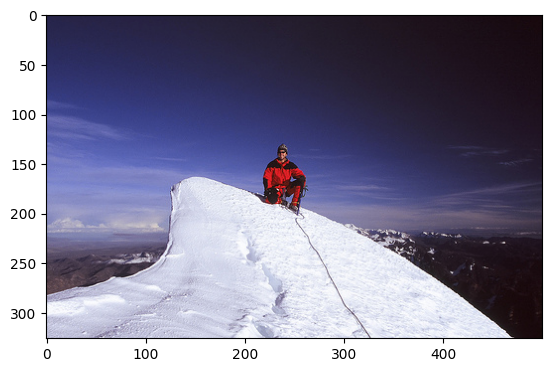

In [60]:
generate_caption(1, unq_test_imgs.iloc[50]['image'])

Actual Caption : 
['A man at the top of a mountain with a beautiful view in the background', 'A man is sitting on a snowbank .', 'A man on a snowy peak .', 'A person in red snow gear is kneeling on a snowy ridge under a blue sky .', 'mountain climber in a red suit poses on snowy peak with mountains in the background']


Predicted caption : 
person is standing in the air on top of the hill in front of snow .


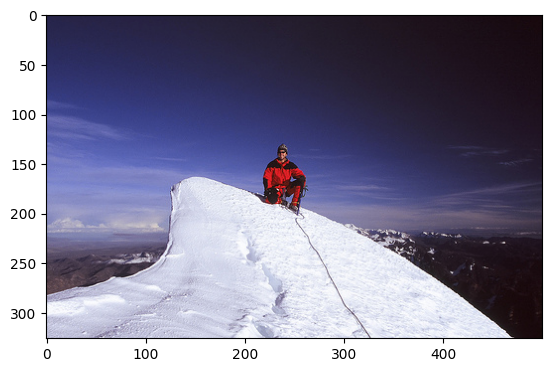

In [69]:
generate_caption(4, unq_test_imgs.iloc[50]['image'])

Actual Caption : 
['Helmeted boy bicyclist on path in the woods .', 'A child is posing on his mountain bike , and wearing a helmet .', 'A boy with a helmet mountain bikes through the woods .', 'A boy dressed in an orange shirt and a helmet is riding a dirt bike in the woods .', 'A boy wearing a helmet on a bicycle in a wooded area .']


Predicted caption : 
man wearing helmet rides bike down path .


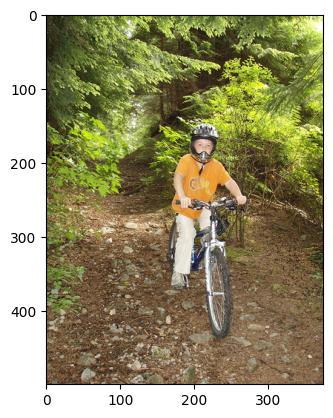

In [70]:
generate_caption(1, unq_test_imgs.iloc[100]['image'])

Actual Caption : 
['Helmeted boy bicyclist on path in the woods .', 'A child is posing on his mountain bike , and wearing a helmet .', 'A boy with a helmet mountain bikes through the woods .', 'A boy dressed in an orange shirt and a helmet is riding a dirt bike in the woods .', 'A boy wearing a helmet on a bicycle in a wooded area .']


Predicted caption : 
young man wearing helmet and jeans helmet is riding bike up dirt path with trees .


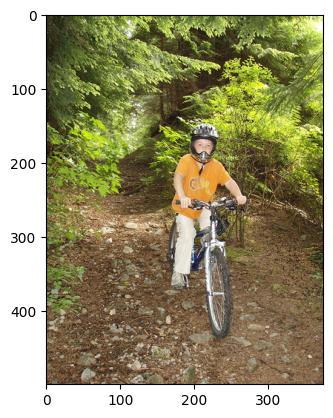

In [176]:
generate_caption(4, unq_test_imgs.iloc[100]['image'])

Actual Caption : 
['A boy with a broken arm is resting in a bed .', 'A boy with a broken arm is sleeping .', 'A boy with his arm wrapped in an ACE bandage rests in a bed .', 'A kid with a broken arm asleep in his bed', 'Child in blue shirt with eye closed and left arm wrapped with ace bandage and propped on a white pillow .']


Predicted caption : 
baby in blue chair and white hat .


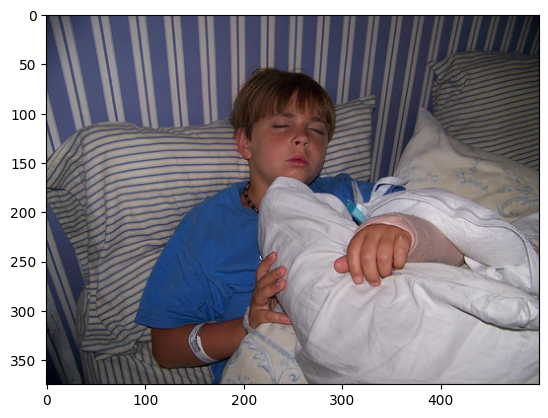

In [84]:
generate_caption(1, unq_test_imgs.iloc[160]['image'])

Actual Caption : 
['A boy with a broken arm is resting in a bed .', 'A boy with a broken arm is sleeping .', 'A boy with his arm wrapped in an ACE bandage rests in a bed .', 'A kid with a broken arm asleep in his bed', 'Child in blue shirt with eye closed and left arm wrapped with ace bandage and propped on a white pillow .']


Predicted caption : 
child is in blue clothes sitting on blanket with baby .


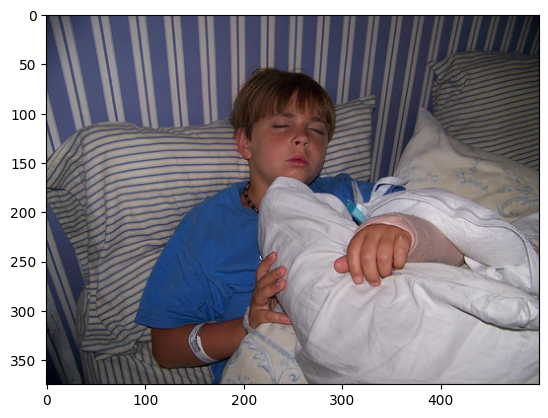

In [85]:
generate_caption(4, unq_test_imgs.iloc[160]['image'])

Actual Caption : 
['The little kid sits down in the muddy water .', 'a very dirty young blond boy playing in the mud .', 'A small boy sits in a mud puddle and gets covered with mud .', 'A child is playing in the muddy water running along a grassy area .', 'A little boy is sitting on a wet path covered in mud .']


Predicted caption : 
little girl in pink shirt and jeans is standing in the water .


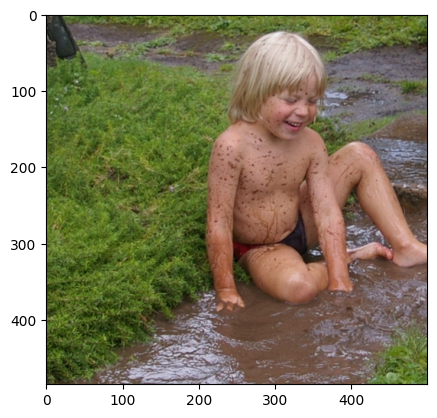

In [111]:
generate_caption(1, unq_test_imgs.iloc[369]['image'])

Actual Caption : 
['The little kid sits down in the muddy water .', 'a very dirty young blond boy playing in the mud .', 'A small boy sits in a mud puddle and gets covered with mud .', 'A child is playing in the muddy water running along a grassy area .', 'A little boy is sitting on a wet path covered in mud .']


Predicted caption : 
little boy is sitting in water and splashing through puddle in puddle .


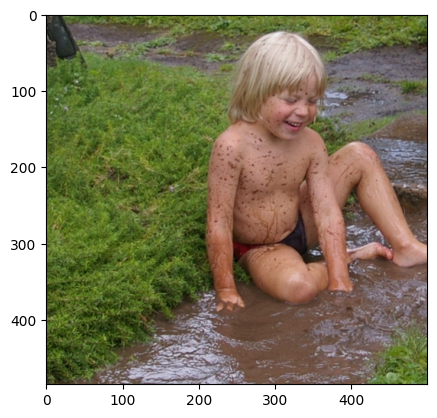

In [109]:
generate_caption(5, unq_test_imgs.iloc[369]['image'])

Actual Caption : 
['Two boys play hockey on a frozen pond .', 'Two children are playing ice hockey on frozen ground outside .', 'Two kids play a game together with sticks in the snow .', 'Two kids play hockey in the snow .', 'Two kids play hockey on a pond .']


Predicted caption : 
two people are playing in the snow .


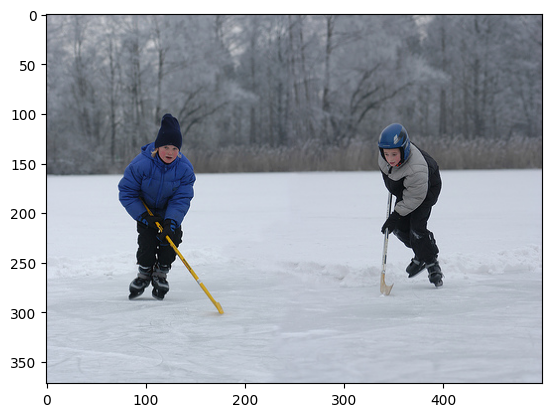

In [120]:
generate_caption(1, unq_test_imgs.iloc[298]['image'])

Actual Caption : 
['Two boys play hockey on a frozen pond .', 'Two children are playing ice hockey on frozen ground outside .', 'Two kids play a game together with sticks in the snow .', 'Two kids play hockey in the snow .', 'Two kids play hockey on a pond .']


Predicted caption : 
two boys are in an ice skating down snow .


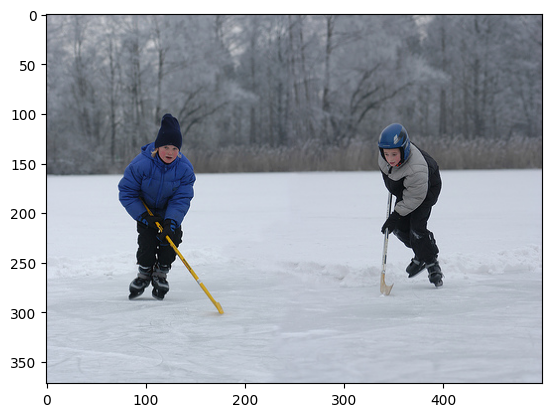

In [173]:
generate_caption(4, unq_test_imgs.iloc[298]['image'])

Actual Caption : 
['One young girl pushing a toy while her twin sister looks on .', 'Two children wearing bright pink clothes are playing with a toy lawnmower .', 'Two girls are dressed the same and one of them is playing with a toy lawnmower .', 'Two little girls stand against a wall , one girl has a happy face and the other girl has a sad face .', 'Two twin girls playing with a toy in the driveway']


Predicted caption : 
little girl in red dress with her hand on the street .


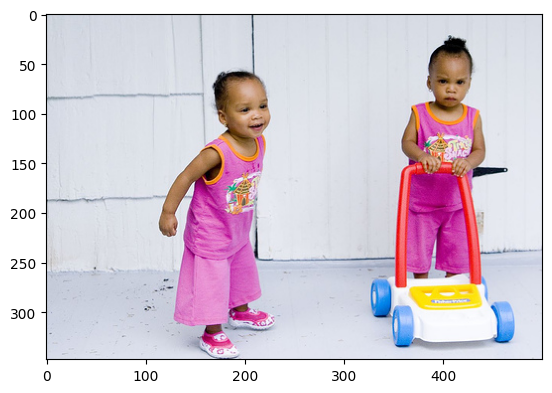

In [61]:
generate_caption(4, unq_test_imgs.iloc[330]['image'])

Actual Caption : 
['Five people are sitting together in the snow .', 'Five children getting ready to sled .', 'A group of people sit in the snow overlooking a mountain scene .', 'A group is sitting around a snowy crevasse .', 'A group of people sit atop a snowy mountain .']


Predicted caption : 
three people on skis in front snow covered hill .


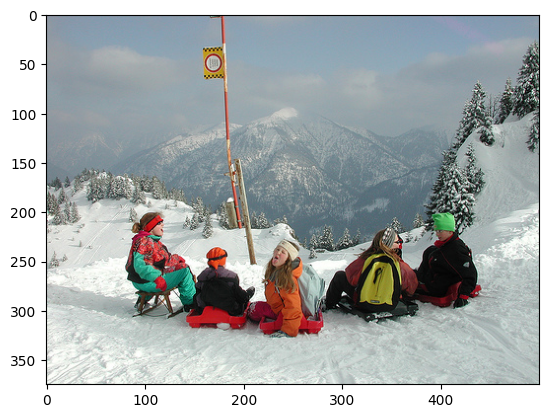

In [64]:
generate_caption(3, unq_test_imgs.iloc[401]['image'])